# Sentiment Analysis and Rating Prediction of Movie Reviews

## intro

### imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import spacy
from nltk.probability import FreqDist
from wordcloud import WordCloud
from wordcloud import STOPWORDS

import joblib

## definitions

In [2]:
def batch_preprocess_texts(
	texts,
	nlp=None,
	remove_stopwords=True,
	remove_punct=True,
	use_lemmas=False,
	disable=["ner"],
	batch_size=50,
	n_process=-1,
):
	"""Efficiently preprocess a collection of texts using nlp.pipe()

	Args:
		texts (collection of strings): collection of texts to process (e.g. df['text'])
		nlp (spacy pipe), optional): Spacy nlp pipe. Defaults to None; if None, it creates a default 'en_core_web_sm' pipe.
		remove_stopwords (bool, optional): Controls stopword removal. Defaults to True.
		remove_punct (bool, optional): Controls punctuation removal. Defaults to True.
		use_lemmas (bool, optional): lemmatize tokens. Defaults to False.
		disable (list of strings, optional): named pipeline elements to disable. Defaults to ["ner"]: Used with nlp.pipe(disable=disable)
		batch_size (int, optional): Number of texts to process in a batch. Defaults to 50.
		n_process (int, optional): Number of CPU processors to use. Defaults to -1 (meaning all CPU cores).

	Returns:
		list of tokens
	"""
	# from tqdm.notebook import tqdm
	from tqdm import tqdm

	if nlp is None:
		nlp = spacy.load("en_core_web_sm")

	processed_texts = []

	for doc in tqdm(nlp.pipe(texts, disable=disable, batch_size=batch_size, n_process=n_process)):
		tokens = []
		for token in doc:
			# Check if should remove stopwords and if token is stopword
			if (remove_stopwords == True) and (token.is_stop == True):
				# Continue the loop with the next token
				continue

			# Check if should remove stopwords and if token is stopword
			if (remove_punct == True) and (token.is_punct == True):
				continue

            # Check if should remove stopwords and if token is stopword
			if (remove_punct == True) and (token.is_space == True):
				continue

            
			## Determine final form of output list of tokens/lemmas
			if use_lemmas:
				tokens.append(token.lemma_.lower())
			else:
				tokens.append(token.text.lower())

		processed_texts.append(tokens)
	return processed_texts


In [3]:
RANDOM_SEED = 42

## Load the data

Load and inspect the dataset.

In [4]:
fpath = 'Data-NLP\movie_reviews_v2.csv'
df = pd.read_csv (fpath)
original_df = df.copy()
df.head()

review_id  movie_id    imdb_id original_title  \
0  64ecc16e83901800af821d50       843  tt0118694           花樣年華   
1  57086ff5c3a3681d29001512      7443  tt0120630    Chicken Run   
2  5bb5ac829251410dcb00810c      7443  tt0120630    Chicken Run   
3  5f0c53a013a32000357ec505      7443  tt0120630    Chicken Run   
4  64ecc027594c9400ffe77c91      7443  tt0120630    Chicken Run   

                                              review  rating  
0  This is a fine piece of cinema from Wong Kar-W...     7.0  
1  A guilty pleasure for me personally, as I love...     9.0  
2  Made my roommate who hates stop-motion animati...     6.0  
3  A very good stop-motion animation!\r\n\r\n<em>...     8.0  
4  Ok, there is an huge temptation to riddle this...     7.0

How many reviews? 8650

In [5]:
df.shape

(8650, 6)

In [6]:
df['review'].isna().sum()

0

## Preprocessing

What does the distribution of ratings look like?

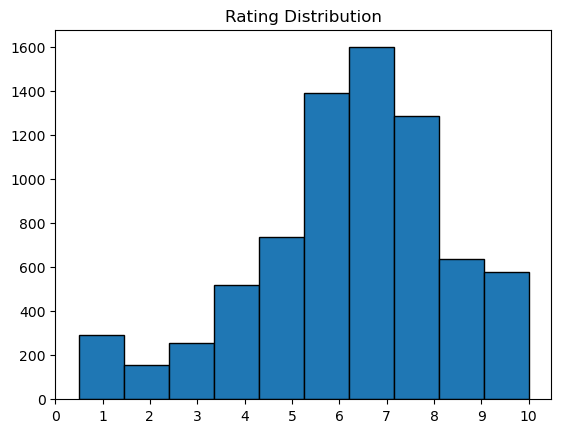

In [7]:
plt.hist(df['rating'], bins=10, edgecolor='black')

plt.title('Rating Distribution')
plt.xticks(np.arange(0, 11, 1));

Any null values?

In [8]:
df.isna().sum()

review_id            0
movie_id             0
imdb_id              0
original_title       0
review               0
rating            1196
dtype: int64

In [9]:
df = df.dropna().reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7454 entries, 0 to 7453
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   review_id       7454 non-null   object 
 1   movie_id        7454 non-null   int64  
 2   imdb_id         7454 non-null   object 
 3   original_title  7454 non-null   object 
 4   review          7454 non-null   object 
 5   rating          7454 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 349.5+ KB


Use the rating column to create a new target column with two groups: high-rating and low-rating groups.

In [10]:
# We recommend defining "High-rating" reviews as any review with a rating >=9; and "Low-rating" reviews as any review with a rating <=4. The middle ratings between 4 and 9 will be excluded from the analysis.
# You may use an alternative definition for High and Low reviews, but justify your choice in your notebook/README.

df = df.drop(df[(df['rating'] > 4) & (df['rating'] < 9)].index).reset_index(drop=True)
df.head()

review_id  movie_id    imdb_id          original_title  \
0  57086ff5c3a3681d29001512      7443  tt0120630             Chicken Run   
1  57b2d23dc3a36837d7000b14       955  tt0120755  Mission: Impossible II   
2  5e9120963679a10018375490       955  tt0120755  Mission: Impossible II   
3  608e2744d8cc4a0058dc4272      2621  tt0122459            Return to Me   
4  6409202f0e441900e887a17b      4234  tt0134084                Scream 3   

                                              review  rating  
0  A guilty pleasure for me personally, as I love...     9.0  
1  The first underwhelmed me, but this one straig...     3.0  
2  After quite entertainign Mission Impossible I ...     2.0  
3  Okay, I will admit I can be a bit of an easy g...     9.0  
4  **_Scream 3’s_ lackluster screenplay and unima...     4.0

In [11]:
df['sentiment'] = df['rating'].apply(lambda x: 'High' if x >= 9 else 'Low')
df.head()

review_id  movie_id    imdb_id          original_title  \
0  57086ff5c3a3681d29001512      7443  tt0120630             Chicken Run   
1  57b2d23dc3a36837d7000b14       955  tt0120755  Mission: Impossible II   
2  5e9120963679a10018375490       955  tt0120755  Mission: Impossible II   
3  608e2744d8cc4a0058dc4272      2621  tt0122459            Return to Me   
4  6409202f0e441900e887a17b      4234  tt0134084                Scream 3   

                                              review  rating sentiment  
0  A guilty pleasure for me personally, as I love...     9.0      High  
1  The first underwhelmed me, but this one straig...     3.0       Low  
2  After quite entertainign Mission Impossible I ...     2.0       Low  
3  Okay, I will admit I can be a bit of an easy g...     9.0      High  
4  **_Scream 3’s_ lackluster screenplay and unima...     4.0       Low

## Text Processing

Utilize NLTK and SpaCy for basic text processing, including:

In [12]:
# removing stopwords

# tokenization

# lemmatization

In [13]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [14]:
pre_proc_path = 'Data-NLP/movie_reviews_preprocessed.csv'
if os.path.exists(pre_proc_path):
  df = pd.read_csv(pre_proc_path)

else:
  df['tokenized_text'] = batch_preprocess_texts(df['review'], nlp=nlp, remove_stopwords=False, remove_punct=False, use_lemmas=False)
  df['lemmatized_text'] = batch_preprocess_texts(df['review'], nlp=nlp, remove_stopwords=True, remove_punct=True, use_lemmas=True)
  df['joined_lemmatized_text'] = df['lemmatized_text'].apply(lambda x: ' '.join(x))
  df['joined_tokenized_text'] = df['tokenized_text'].apply(lambda x: ' '.join(x))
  df.to_csv(pre_proc_path)


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2419 entries, 0 to 2418
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              2419 non-null   int64  
 1   review_id               2419 non-null   object 
 2   movie_id                2419 non-null   int64  
 3   imdb_id                 2419 non-null   object 
 4   original_title          2419 non-null   object 
 5   review                  2419 non-null   object 
 6   rating                  2419 non-null   float64
 7   sentiment               2419 non-null   object 
 8   tokenized_text          2419 non-null   object 
 9   lemmatized_text         2419 non-null   object 
 10  joined_lemmatized_text  2419 non-null   object 
 11  joined_tokenized_text   2419 non-null   object 
dtypes: float64(1), int64(2), object(9)
memory usage: 226.9+ KB


In [43]:
df.head()

Unnamed: 0                 review_id  movie_id    imdb_id  \
0           0  57086ff5c3a3681d29001512      7443  tt0120630   
1           1  57b2d23dc3a36837d7000b14       955  tt0120755   
2           2  5e9120963679a10018375490       955  tt0120755   
3           3  608e2744d8cc4a0058dc4272      2621  tt0122459   
4           4  6409202f0e441900e887a17b      4234  tt0134084   

           original_title                                             review  \
0             Chicken Run  A guilty pleasure for me personally, as I love...   
1  Mission: Impossible II  The first underwhelmed me, but this one straig...   
2  Mission: Impossible II  After quite entertainign Mission Impossible I ...   
3            Return to Me  Okay, I will admit I can be a bit of an easy g...   
4                Scream 3  **_Scream 3’s_ lackluster screenplay and unima...   

   rating sentiment                                     tokenized_text  \
0     9.0      High  ['a', 'guilty', 'pleasure', 'for', 'me', 'pers...   
1     3.0       Low  ['the', 'first', 'underwhelmed', 'me', ',', 'b...   
2     2.0       Low  ['after', 'quite', 'entertainign', 'mission', ...   
3     9.0      High  ['okay', ',', 'i', 'will', 'admit', 'i', 'can'...   
4     4.0       Low  ['*', '*', '_', 'scream', '3', '’s', '_', 'lac...   

                                     lemmatized_text  \
0  ['guilty', 'pleasure', 'personally', 'love', '...   
1  ['underwhelme', 'straight', 'bore', 'course', ...   
2  ['entertainign', 'mission', 'impossible', 'sec...   
3  ['okay', 'admit', 'bit', 'easy', 'grader', 'co...   
4  ['scream', '3', 'lackluster', 'screenplay', 'u...   

                              joined_lemmatized_text  \
0  guilty pleasure personally love great escape w...   
1  underwhelme straight bore course see hunt clim...   
2  entertainign mission impossible second install...   
3  okay admit bit easy grader come romantic comed...   
4  scream 3 lackluster screenplay unimaginative k...   

                               joined_tokenized_text  
0  a guilty pleasure for me personally , as i lov...  
1  the first underwhelmed me , but this one strai...  
2  after quite entertainign mission impossible i ...  
3  okay , i will admit i can be a bit of an easy ...  
4  * * _ scream 3 ’s _ lackluster screenplay and ...

In [44]:
original_df.head()

review_id  movie_id    imdb_id original_title  \
0  64ecc16e83901800af821d50       843  tt0118694           花樣年華   
1  57086ff5c3a3681d29001512      7443  tt0120630    Chicken Run   
2  5bb5ac829251410dcb00810c      7443  tt0120630    Chicken Run   
3  5f0c53a013a32000357ec505      7443  tt0120630    Chicken Run   
4  64ecc027594c9400ffe77c91      7443  tt0120630    Chicken Run   

                                              review  rating  
0  This is a fine piece of cinema from Wong Kar-W...     7.0  
1  A guilty pleasure for me personally, as I love...     9.0  
2  Made my roommate who hates stop-motion animati...     6.0  
3  A very good stop-motion animation!\r\n\r\n<em>...     8.0  
4  Ok, there is an huge temptation to riddle this...     7.0

In [ ]:
# save as a joblib file
joblib.dump(df, 'Data-NLP/movie_reviews_preprocessed.pkl')


In [17]:
# Tips:
# Be sure to create a custom nlp object and disable the named entity recognizer. Otherwise, processing will take a very long time!
# You will want to create several versions of the data, lemmatized, tokenized, lemmatized joined back to one string per review, and tokenized joined back to one string per review. This will be useful for different analysis and modeling techniques.
# ​Note: you may find some artifacts during your EDA e.g. HTML code like "href". You are allowed to drop rows from your dataset after identifying problematic trends in some of the texts.  (Hint: remember df[col].str.contains)

## EDA & Visualization

In [18]:
low_ratings = df.loc[df['sentiment'] == 'Low']
high_ratings = df.loc[df['sentiment'] == 'High']

low_ratings.head()

Unnamed: 0                 review_id  movie_id    imdb_id  \
1            1  57b2d23dc3a36837d7000b14       955  tt0120755   
2            2  5e9120963679a10018375490       955  tt0120755   
4            4  6409202f0e441900e887a17b      4234  tt0134084   
9            9  63578ba8c8a2d4008a00ff77     12211  tt0144964   
13          13  6110271465e0a2002683d2b6       479  tt0162650   

            original_title                                             review  \
1   Mission: Impossible II  The first underwhelmed me, but this one straig...   
2   Mission: Impossible II  After quite entertainign Mission Impossible I ...   
4                 Scream 3  **_Scream 3’s_ lackluster screenplay and unima...   
9      Highlander: Endgame  **There should have been only one!**\r\n\r\nIf...   
13                   Shaft  _**A black detective in Gotham desperately wan...   

    rating sentiment                                     tokenized_text  \
1      3.0       Low  ['the', 'first', 'underwhelmed', 'me', ',', 'b...   
2      2.0       Low  ['after', 'quite', 'entertainign', 'mission', ...   
4      4.0       Low  ['*', '*', '_', 'scream', '3', '’s', '_', 'lac...   
9      1.0       Low  ['*', '*', 'there', 'should', 'have', 'been', ...   
13     4.0       Low  ['_', '*', '*', 'a', 'black', 'detective', 'in...   

                                      lemmatized_text  \
1   ['underwhelme', 'straight', 'bore', 'course', ...   
2   ['entertainign', 'mission', 'impossible', 'sec...   
4   ['scream', '3', 'lackluster', 'screenplay', 'u...   
9   ['highlander', '2', 'complete', 'disgrace', 'h...   
13  ['black', 'detective', 'gotham', 'desperately'...   

                               joined_lemmatized_text  \
1   underwhelme straight bore course see hunt clim...   
2   entertainign mission impossible second install...   
4   scream 3 lackluster screenplay unimaginative k...   
9   highlander 2 complete disgrace highlander 3 tr...   
13  black detective gotham desperately want nail s...   

                                joined_tokenized_text  
1   the first underwhelmed me , but this one strai...  
2   after quite entertainign mission impossible i ...  
4   * * _ scream 3 ’s _ lackluster screenplay and ...  
9   * * there should have been only one ! * * \r\n...  
13  _ * * a black detective in gotham desperately ...

In [19]:
high_ratings.head()

Unnamed: 0                 review_id  movie_id    imdb_id original_title  \
0           0  57086ff5c3a3681d29001512      7443  tt0120630    Chicken Run   
3           3  608e2744d8cc4a0058dc4272      2621  tt0122459   Return to Me   
5           5  5570c897c3a368709c000bca      2787  tt0134847    Pitch Black   
6           6  5b92026d0e0a26609c005caa      2787  tt0134847    Pitch Black   
7           7  5f98ecffae36680036bc7170      2787  tt0134847    Pitch Black   

                                              review  rating sentiment  \
0  A guilty pleasure for me personally, as I love...     9.0      High   
3  Okay, I will admit I can be a bit of an easy g...     9.0      High   
5  All you people are so scared of me. Most days ...     9.0      High   
6  One of those few movies that most people don't...     9.0      High   
7  The movie that put Vin Diesel on the map as Ri...     9.0      High   

                                      tokenized_text  \
0  ['a', 'guilty', 'pleasure', 'for', 'me', 'pers...   
3  ['okay', ',', 'i', 'will', 'admit', 'i', 'can'...   
5  ['all', 'you', 'people', 'are', 'so', 'scared'...   
6  ['one', 'of', 'those', 'few', 'movies', 'that'...   
7  ['the', 'movie', 'that', 'put', 'vin', 'diesel...   

                                     lemmatized_text  \
0  ['guilty', 'pleasure', 'personally', 'love', '...   
3  ['okay', 'admit', 'bit', 'easy', 'grader', 'co...   
5  ['people', 'scared', 'day', 'compliment', 'be'...   
6  ['movie', 'people', 'care', 'personally', 'thi...   
7  ['movie', 'vin', 'diesel', 'map', 'riddick', '...   

                              joined_lemmatized_text  \
0  guilty pleasure personally love great escape w...   
3  okay admit bit easy grader come romantic comed...   
5  people scared day compliment be got to worry p...   
6  movie people care personally think criminally ...   
7  movie vin diesel map riddick crooked anti hero...   

                               joined_tokenized_text  
0  a guilty pleasure for me personally , as i lov...  
3  okay , i will admit i can be a bit of an easy ...  
5  all you people are so scared of me . most days...  
6  one of those few movies that most people do n'...  
7  the movie that put vin diesel on the map as ri...

Create word clouds to visualize the most frequent and significant words in each group.

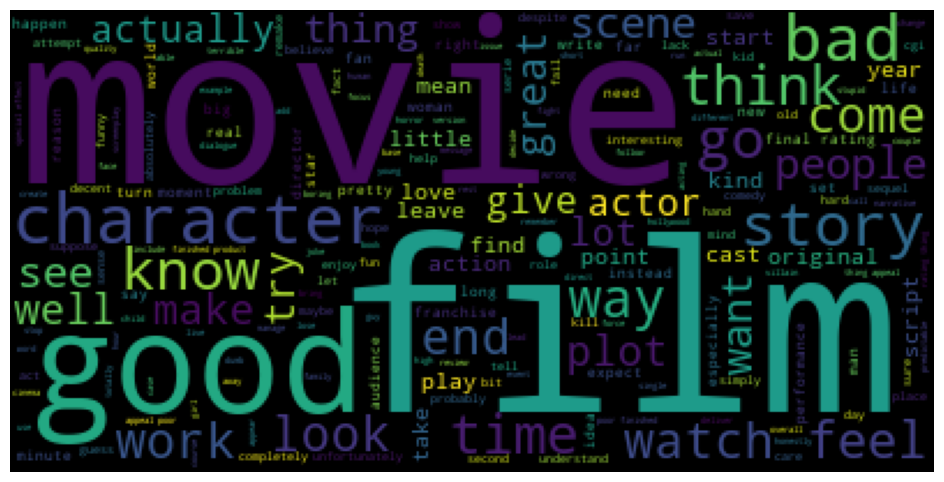

In [20]:
cloud_low = WordCloud(random_state = RANDOM_SEED).generate(' '.join(low_ratings['joined_lemmatized_text']))

plt.figure(figsize = (12, 6))
plt.imshow(cloud_low)
plt.axis('off');

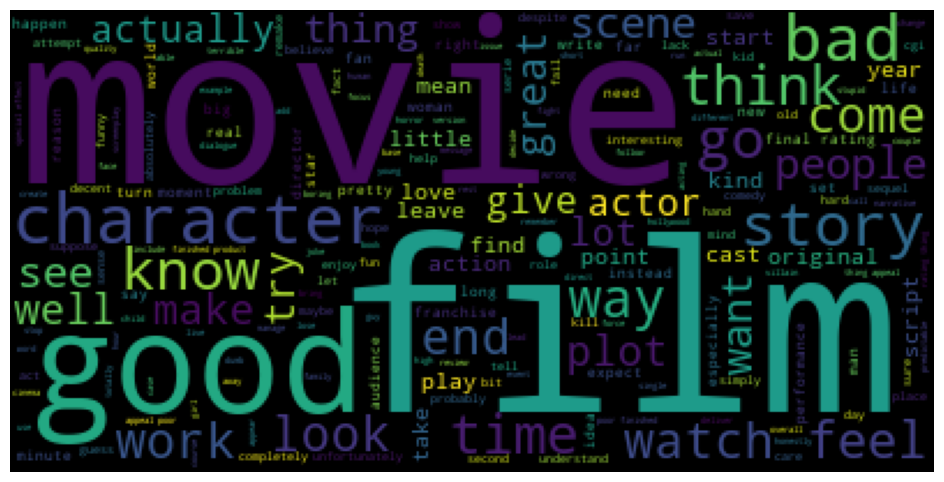

In [21]:
cloud_high = WordCloud(random_state = RANDOM_SEED).generate(' '.join(high_ratings['joined_lemmatized_text']))

plt.figure(figsize = (12, 6))
plt.imshow(cloud_low)
plt.axis('off');

Save your wordclouds as .png files in the "Images/" folder in your repo.

Apply nltk's FreqDist class to compare the frequency distribution of words in the review groups.

In [22]:
tokens_low = batch_preprocess_texts(low_ratings['review'], batch_size = 1000)
tokens_low = tokens_low[0]

1224it [01:12, 16.81it/s] 


In [23]:
tokens_high = batch_preprocess_texts(high_ratings['review'], batch_size = 1000)
tokens_high = tokens_high[0]

1195it [01:50, 10.78it/s] 


compare low and high rated

In [24]:
pd.DataFrame([tokens_low, tokens_high]).T.rename(columns={0: 'low_rated', 1: 'high_rated'})

low_rated   high_rated
0     underwhelmed       guilty
1         straight     pleasure
2            bored   personally
3           course         love
4           seeing        great
5             hunt       escape
6            climb        works
7         mountain         seen
8          harness        years
9       impressive   rightfully
10            sure     esteemed
11           liked      british
12            idea    animation
13         villain      company
14           piece       highly
15           angle  recommended
16        woefully     children
17  underdeveloped       adults
18         setting        enjoy
19   predominantly    animation
20       australia         None
21            grab         None
22       attention         None
23          saying         None
24           cause         None
25          pretty         None
26          biased         None
27           comes         None
28            hear         None
29            tell         None
30         mission         None
31      impossible         None
32              ii         None
33             low         None
34           point         None
35          series         None
36     encouraging         None
37           worse         None
38            know         None
39            able         None
40           rogue         None
41          nation         None
42           final         None
43         rating:         None
44               ★         None
45               ½         None
46          boring         None
47   disappointing         None
48           avoid         None
49        possible         None

In [46]:
high_ratings.head()

Unnamed: 0                 review_id  movie_id    imdb_id original_title  \
0           0  57086ff5c3a3681d29001512      7443  tt0120630    Chicken Run   
3           3  608e2744d8cc4a0058dc4272      2621  tt0122459   Return to Me   
5           5  5570c897c3a368709c000bca      2787  tt0134847    Pitch Black   
6           6  5b92026d0e0a26609c005caa      2787  tt0134847    Pitch Black   
7           7  5f98ecffae36680036bc7170      2787  tt0134847    Pitch Black   

                                              review  rating sentiment  \
0  A guilty pleasure for me personally, as I love...     9.0      High   
3  Okay, I will admit I can be a bit of an easy g...     9.0      High   
5  All you people are so scared of me. Most days ...     9.0      High   
6  One of those few movies that most people don't...     9.0      High   
7  The movie that put Vin Diesel on the map as Ri...     9.0      High   

                                      tokenized_text  \
0  ['a', 'guilty', 'pleasure', 'for', 'me', 'pers...   
3  ['okay', ',', 'i', 'will', 'admit', 'i', 'can'...   
5  ['all', 'you', 'people', 'are', 'so', 'scared'...   
6  ['one', 'of', 'those', 'few', 'movies', 'that'...   
7  ['the', 'movie', 'that', 'put', 'vin', 'diesel...   

                                     lemmatized_text  \
0  ['guilty', 'pleasure', 'personally', 'love', '...   
3  ['okay', 'admit', 'bit', 'easy', 'grader', 'co...   
5  ['people', 'scared', 'day', 'compliment', 'be'...   
6  ['movie', 'people', 'care', 'personally', 'thi...   
7  ['movie', 'vin', 'diesel', 'map', 'riddick', '...   

                              joined_lemmatized_text  \
0  guilty pleasure personally love great escape w...   
3  okay admit bit easy grader come romantic comed...   
5  people scared day compliment be got to worry p...   
6  movie people care personally think criminally ...   
7  movie vin diesel map riddick crooked anti hero...   

                               joined_tokenized_text  
0  a guilty pleasure for me personally , as i lov...  
3  okay , i will admit i can be a bit of an easy ...  
5  all you people are so scared of me . most days...  
6  one of those few movies that most people do n'...  
7  the movie that put vin diesel on the map as ri...

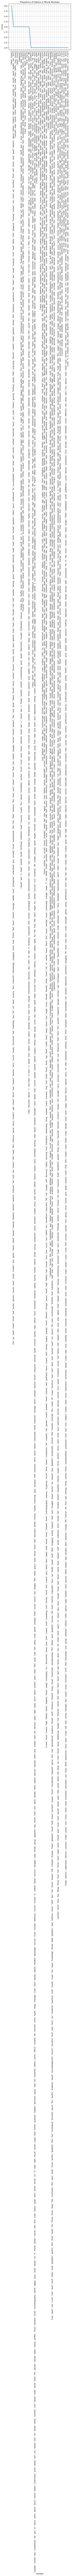

In [45]:
dist = high_ratings['lemmatized_text'].explode().to_list()

dist = FreqDist(dist)
# Plot top 30
dist.plot(30, title = 'Frequency of tokens in Movie Reviews');
# dist

In [26]:
# Remember, you can use this analysis to identify additional custom EDA stop words to use for visualization. (e.g., if the words are common in both groups)
custom_stops = ['movie', 'film', 'good', 'story', 'character', 'ii', '★', '45',	'½', 'time', 'watch', 'feel', 'think', 'go', 'know']

stops = [*STOPWORDS, *custom_stops]

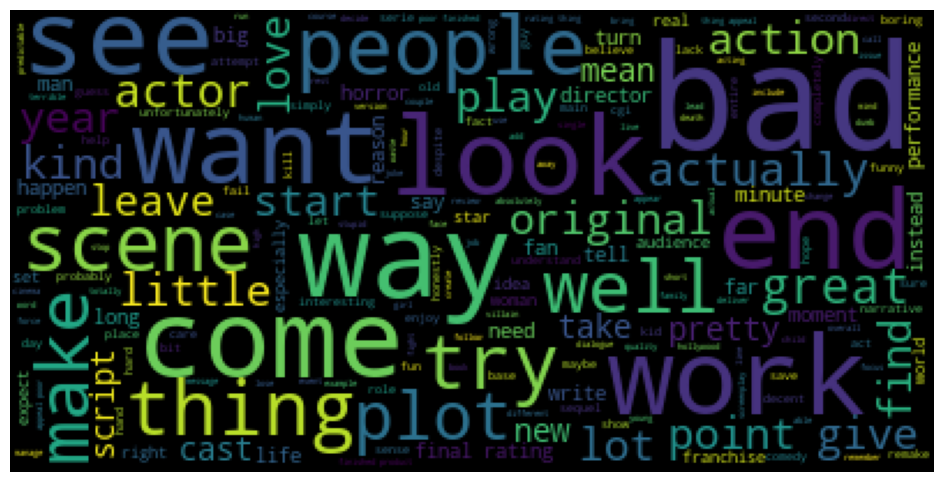

In [27]:
# # Remove stopwords from the wordcloud
low_cloud = WordCloud(random_state=123, stopwords=stops).generate(' '.join(low_ratings['joined_lemmatized_text']))

plt.figure(figsize = (12, 6))
plt.imshow(low_cloud);
plt.axis('off');

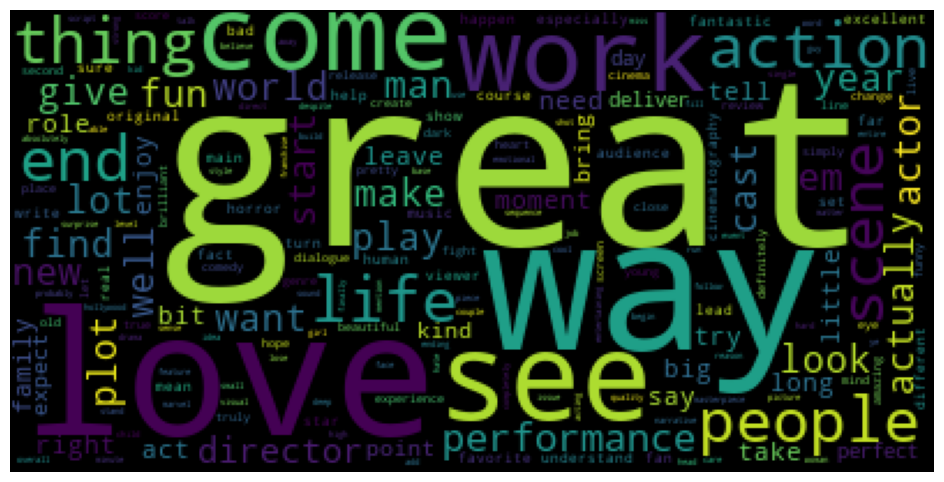

In [28]:
# # Remove stopwords from the wordcloud
high_cloud = WordCloud(random_state=123, stopwords=stops).generate(' '.join(high_ratings['joined_lemmatized_text']))

plt.figure(figsize = (12, 6))
plt.imshow(high_cloud);
plt.axis('off');

In [29]:
low_rating_freqs = pd.DataFrame(low_cloud.words_, index = range(0,200)).T.reset_index().rename(columns = {'index': 'word', 0: 'frequency'})[['word', 'frequency']]
high_rating_freqs = pd.DataFrame(high_cloud.words_, index = range(0,200)).T.reset_index().rename(columns = {'index': 'word', 0: 'frequency'})[['word', 'frequency']]

In [30]:
low_rating_freqs.head(10)

word  frequency
0     bad   1.000000
1     way   0.626100
2    come   0.558651
3     end   0.533724
4    look   0.526393
5    work   0.526393
6     see   0.510264
7    want   0.485337
8  people   0.483871
9   scene   0.469208

In [31]:
high_rating_freqs.head(10)

word  frequency
0   great   1.000000
1     way   0.801858
2    love   0.736842
3     see   0.732198
4    come   0.684211
5    work   0.656347
6  people   0.628483
7     end   0.606811
8   thing   0.588235
9  action   0.588235

In [32]:
df.head()

Unnamed: 0                 review_id  movie_id    imdb_id  \
0           0  57086ff5c3a3681d29001512      7443  tt0120630   
1           1  57b2d23dc3a36837d7000b14       955  tt0120755   
2           2  5e9120963679a10018375490       955  tt0120755   
3           3  608e2744d8cc4a0058dc4272      2621  tt0122459   
4           4  6409202f0e441900e887a17b      4234  tt0134084   

           original_title                                             review  \
0             Chicken Run  A guilty pleasure for me personally, as I love...   
1  Mission: Impossible II  The first underwhelmed me, but this one straig...   
2  Mission: Impossible II  After quite entertainign Mission Impossible I ...   
3            Return to Me  Okay, I will admit I can be a bit of an easy g...   
4                Scream 3  **_Scream 3’s_ lackluster screenplay and unima...   

   rating sentiment                                     tokenized_text  \
0     9.0      High  ['a', 'guilty', 'pleasure', 'for', 'me', 'pers...   
1     3.0       Low  ['the', 'first', 'underwhelmed', 'me', ',', 'b...   
2     2.0       Low  ['after', 'quite', 'entertainign', 'mission', ...   
3     9.0      High  ['okay', ',', 'i', 'will', 'admit', 'i', 'can'...   
4     4.0       Low  ['*', '*', '_', 'scream', '3', '’s', '_', 'lac...   

                                     lemmatized_text  \
0  ['guilty', 'pleasure', 'personally', 'love', '...   
1  ['underwhelme', 'straight', 'bore', 'course', ...   
2  ['entertainign', 'mission', 'impossible', 'sec...   
3  ['okay', 'admit', 'bit', 'easy', 'grader', 'co...   
4  ['scream', '3', 'lackluster', 'screenplay', 'u...   

                              joined_lemmatized_text  \
0  guilty pleasure personally love great escape w...   
1  underwhelme straight bore course see hunt clim...   
2  entertainign mission impossible second install...   
3  okay admit bit easy grader come romantic comed...   
4  scream 3 lackluster screenplay unimaginative k...   

                               joined_tokenized_text  
0  a guilty pleasure for me personally , as i lov...  
1  the first underwhelmed me , but this one strai...  
2  after quite entertainign mission impossible i ...  
3  okay , i will admit i can be a bit of an easy ...  
4  * * _ scream 3 ’s _ lackluster screenplay and ...

In [33]:
new_stopwords = ['way', 'work', 'come', 'end', 'see', 'people']
stops.extend(new_stopwords)
stops

["you're",
 "hadn't",
 'how',
 'himself',
 "shouldn't",
 "you'll",
 'own',
 "they'd",
 'if',
 "hasn't",
 "shan't",
 'else',
 'has',
 "wasn't",
 'ever',
 'ourselves',
 'very',
 'who',
 'had',
 'however',
 'you',
 'which',
 "what's",
 'your',
 'few',
 'or',
 "she's",
 "here's",
 'before',
 "you've",
 'com',
 'did',
 'some',
 'for',
 "he'll",
 "isn't",
 'since',
 'more',
 'i',
 "doesn't",
 "there's",
 'about',
 "won't",
 'into',
 'me',
 'just',
 'nor',
 'until',
 'why',
 "didn't",
 'these',
 'down',
 'therefore',
 'her',
 'in',
 "it's",
 "let's",
 'k',
 'that',
 'after',
 'it',
 'themselves',
 'would',
 'no',
 'hence',
 'yours',
 "i'm",
 'above',
 'below',
 'further',
 'were',
 'have',
 'by',
 'can',
 'does',
 'here',
 "when's",
 'on',
 'a',
 'over',
 'than',
 'being',
 'other',
 'herself',
 'cannot',
 'once',
 'under',
 'again',
 'between',
 'get',
 'any',
 'with',
 'same',
 'too',
 'all',
 "they're",
 "they'll",
 "he's",
 'am',
 'their',
 'www',
 'hers',
 "who's",
 "don't",
 "where's",


new low ratings cloud

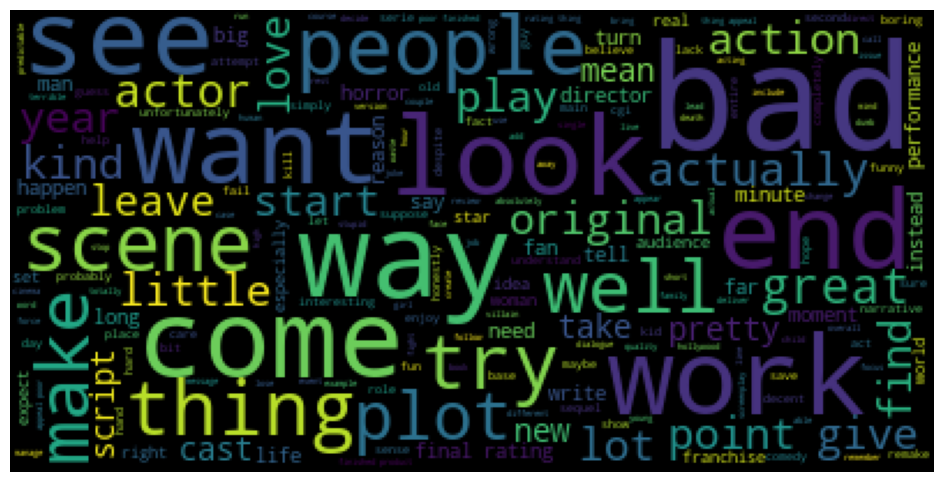

In [34]:
# # Remove stopwords from the wordcloud
new_low_cloud = WordCloud(random_state=123, stopwords=stops).generate(' '.join(low_ratings['joined_lemmatized_text']))

plt.figure(figsize = (12, 6))
plt.imshow(low_cloud);
plt.axis('off');

new high ratings cloud

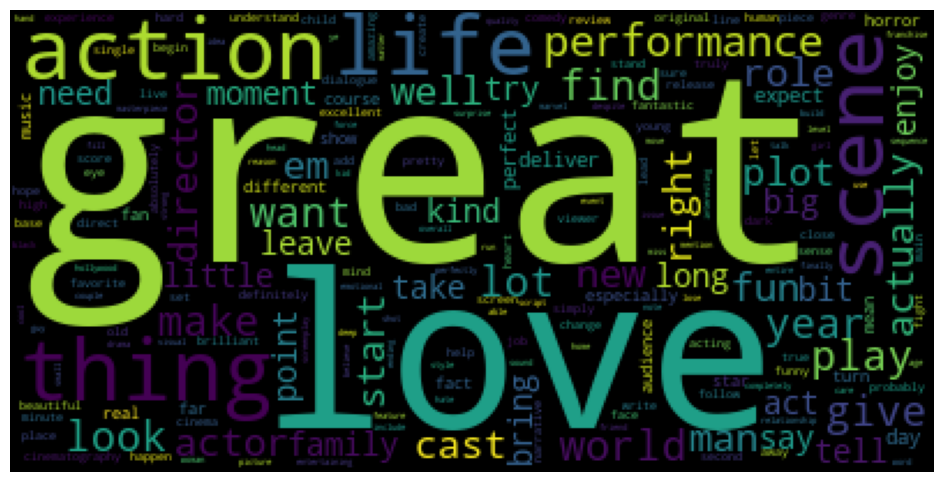

In [35]:
# # Remove stopwords from the wordcloud
high_cloud = WordCloud(random_state=123, stopwords=stops).generate(' '.join(high_ratings['joined_lemmatized_text']))

plt.figure(figsize = (12, 6))
plt.imshow(high_cloud);
plt.axis('off');

In [36]:
# 
# Remember, you can use this analysis to identify additional custom EDA stop words to use for visualization. (e.g., if the words are common in both groups)
# Save your freq dist plots as .png files in the "Images/" folder in your repo.
# Perform n-grams analysis (bigrams and trigrams),


In [37]:
all_tokens_high = []
for tokens in high_ratings['tokenized_text']:
  all_tokens_high = all_tokens_high + tokens.split(', ')


all_tokens_low = []
for tokens in low_ratings['tokenized_text']:
  all_tokens_low.extend(tokens)

) missing from current font.s\dojo-env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


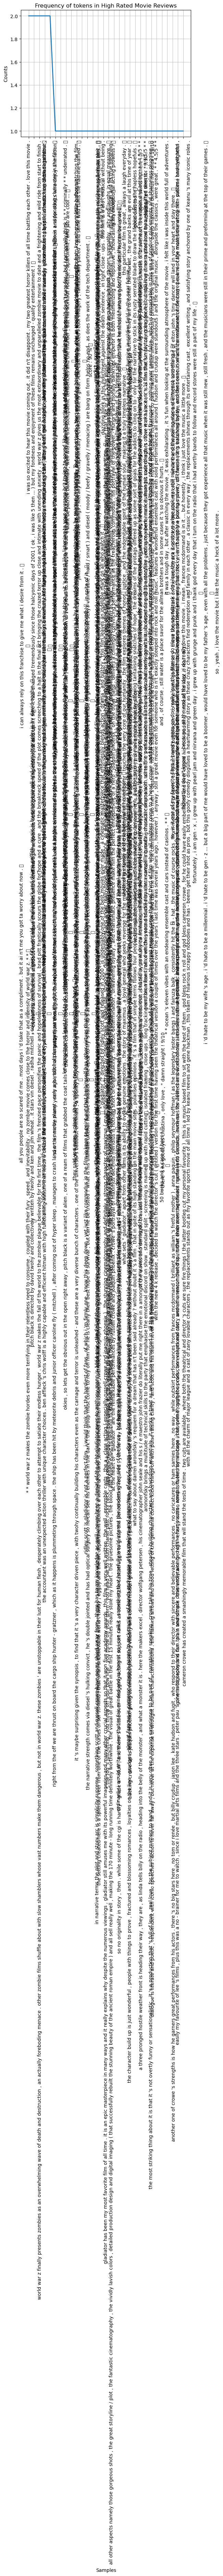

FreqDist({"i was so excited to hear this movie coming out . it did n't disappoint . my two greatest horror killers of all time battling each other . love this movie .": 2, "* * world war z makes the zombie hordes even more terrifying in their relentless need to consume , coupled with their fury , speed , and inevitability . no zombie movie comes close to the horror and intensity of world war z. * * \r\n\r\n world war z finally presents zombies as an overwhelming wave of death and destruction , an actually foreboding menace . other zombie films shuffle about with slow shamblers whose vast numbers make them dangerous , but not in world war z. these zombies ' are unstoppable in their lust for human flesh , desperately climbing over each other to attempt to satiate their endless hunger . world war z makes the fall of the world to the zombie plague believable for the first time . the film 's frenzied pace personifies the panic and hopelessness of survival . brad pitt frantically scours the 

In [38]:
# dist = FreqDist(all_tokens_high)
dist = FreqDist(high_ratings['joined_tokenized_text'])

# Plot top 30
dist.plot(30, title = 'Frequency of tokens in High Rated Movie Reviews');
dist

In [39]:
low_ratings.head()


Unnamed: 0                 review_id  movie_id    imdb_id  \
1            1  57b2d23dc3a36837d7000b14       955  tt0120755   
2            2  5e9120963679a10018375490       955  tt0120755   
4            4  6409202f0e441900e887a17b      4234  tt0134084   
9            9  63578ba8c8a2d4008a00ff77     12211  tt0144964   
13          13  6110271465e0a2002683d2b6       479  tt0162650   

            original_title                                             review  \
1   Mission: Impossible II  The first underwhelmed me, but this one straig...   
2   Mission: Impossible II  After quite entertainign Mission Impossible I ...   
4                 Scream 3  **_Scream 3’s_ lackluster screenplay and unima...   
9      Highlander: Endgame  **There should have been only one!**\r\n\r\nIf...   
13                   Shaft  _**A black detective in Gotham desperately wan...   

    rating sentiment                                     tokenized_text  \
1      3.0       Low  ['the', 'first', 'underwhelmed', 'me', ',', 'b...   
2      2.0       Low  ['after', 'quite', 'entertainign', 'mission', ...   
4      4.0       Low  ['*', '*', '_', 'scream', '3', '’s', '_', 'lac...   
9      1.0       Low  ['*', '*', 'there', 'should', 'have', 'been', ...   
13     4.0       Low  ['_', '*', '*', 'a', 'black', 'detective', 'in...   

                                      lemmatized_text  \
1   ['underwhelme', 'straight', 'bore', 'course', ...   
2   ['entertainign', 'mission', 'impossible', 'sec...   
4   ['scream', '3', 'lackluster', 'screenplay', 'u...   
9   ['highlander', '2', 'complete', 'disgrace', 'h...   
13  ['black', 'detective', 'gotham', 'desperately'...   

                               joined_lemmatized_text  \
1   underwhelme straight bore course see hunt clim...   
2   entertainign mission impossible second install...   
4   scream 3 lackluster screenplay unimaginative k...   
9   highlander 2 complete disgrace highlander 3 tr...   
13  black detective gotham desperately want nail s...   

                                joined_tokenized_text  
1   the first underwhelmed me , but this one strai...  
2   after quite entertainign mission impossible i ...  
4   * * _ scream 3 ’s _ lackluster screenplay and ...  
9   * * there should have been only one ! * * \r\n...  
13  _ * * a black detective in gotham desperately ...

In [40]:

# Remember, you can use this analysis to identify additional custom stop words to use for EDA. (e.g., if the words are common in both groups)
# Focus on bigrams or trigrams, using NLTK's BigramCollocationFinder and BigramAssocMeasures classes (or the Trigram equivalent Finder and Measures) to explore commonly used groups of words for each rating-group.
# Describe any differences. What do these differences tell you?
# Save your data frame comparison of the top ngrams for each group as a Markdown table.
#  You can use the df.to_markdown() method to create a string version of your data frame that can be copied and pasted into a Markdown cell and your README.

# Perform sentiment analysis to create polarity scores according to VADERS's sentiment lexicon.

# Compare the sentiments of high-rating and low-rating texts.

# Compare the compound sentiment scores for high and low-rating reviews.

# Which review polarity scores don't match the ratings? Why do you think this is?

# 3) Evaluation and Reporting:

# Based on your analyses, what should someone do (or not do) if they want to make a highly-rated movie?

# List 3 things associated with high-rating reviews
# List 3 things associated with low-rating reviews.


# Update your project README with a new section for "NLP Analysis of Movie Reviews."
# Include what reviews were used (source and what the original rating numbers were before they were converted to a categorical target).
# Include your EDA visualizations in your README:
# One wordcloud comparing both groups
# Two FreqDists plots (1 per group)
# A Markdown table of the Top Ngrams for each group.
# Your recommendations/conclusions for what to do/not to do make a highly-rated movie.
# Deliverables:

# Notebook files for preprocessing and EDA
# EDA Images saved in an "Images" folder.
# Updated README 
# These should be submitted as the link to a repository with an appropriate name (NOT "Project 2"). Note: you can rename your project on GitHub.com by clicking on the Settings for your repo. The first option should be "Repository Name"



# Support and References:
# Students are encouraged to consult the official documentation of NLTK, SpaCy, wordcloud, and Scikit-Learn, as well as the Learn Platform.